# Analysis on correlation between earthquakes and surface mass loading in individual mascons

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from global_land_mask import globe
import scipy.stats as stats
import os
import importlib
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import numpy.ma as ma
from tqdm import tqdm
from shapely.geometry import Point, Polygon

# file containing functions:
import loadquakes
importlib.reload(loadquakes)

<module 'loadquakes' from '/Users/amandasyamsul/SLIQ/loadquakes.py'>

## 1. Load datasets

- GRACE and GRACE-FO
- USGS earthquake catalog with ETAS probabilities

In [2]:
# GRACE data
ds = xr.open_dataset("GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc")

# Catalog of events from 2002-04-16 to 2022-1-16 with magnitude >= 5.4
catalog = pd.read_csv('catalog.csv')
etas_declustered = pd.read_csv('etas_declustered.csv')

## 2.1 Analyze correlation between all events (n=12573) and surface mass loading by mascon

###  This method calculates LgE and L using mascons from the JPL mascon placement file

In [3]:
'''
Calculates conditional probability P(E|L) using loads during earthquakes (LgE) and loads during all time periods (L)

'''

def get_cp(LgE, L):
    cp_list = []  
    
    bins = np.linspace(-80,80,80)

    LgE_hist = np.histogram(LgE, bins=bins, density=True)[0] 
    L_hist = np.histogram(L, bins=bins, density=True)[0]

    cp = np.divide(LgE_hist, L_hist, out=np.zeros_like(LgE_hist), where=L_hist != 0)

    return bins, cp  #  list of cps for all mascons that contain earthquakes

In [4]:
mascon = xr.open_dataset('JPL_MSCNv03_PLACEMENT.nc')
mascon_center_lat = mascon['mascon_lat'].data
mascon_center_lon = mascon['mascon_lon'].data
mascon_id = mascon['mascon_id'].data

lwe_data = ds.lwe_thickness
cap_radius_deg = 1.5  # Spherical cap radius in degrees

In [5]:
'''
Full catalog - Convert earthquake data to a GeoDataFrame
'''
# Convert lon and lat to Shapely Point objects
geometry_full = [Point(xy) for xy in zip(catalog['longitude'], catalog['latitude'])]

# GeoDataFrame for the full earthquake catalog
catalog_gdf_full = gpd.GeoDataFrame(catalog, geometry=geometry_full, crs="EPSG:4326")  
# EPSG:4326 specifies the coordinate reference system (WGS 84)
catalog_gdf_full.sindex

'''
ETAS Declustered Catalog - Convert ETAS declustered earthquake data to a GeoDataFrame
'''
# Convert ETAS catalog's coordinates into Shapely Point objects
geometry_etas = [Point(xy) for xy in zip(etas_declustered['longitude'], etas_declustered['latitude'])]

# GeoDataFrame for the ETAS declustered catalog
catalog_gdf_etas = gpd.GeoDataFrame(etas_declustered, geometry=geometry_etas, crs="EPSG:4326")
catalog_gdf_etas.sindex

In [6]:
def calc_cp_by_mascon_lag(catalog_gdf, loads, taus):
    """
    Calculates conditional probability P(E|L_tau) in every mascon using each mascon's center coordinates 
    and creating a 1.5-degree radius spherical cap around each one.
    
    Parameters:
    -----------
    catalog_gdf: Earthquake catalog with 'time' (datetime64) and 'dmass' columns.
    loads:       GRACE-derived surface load dataset with 'time', 'lat', 'lon' dimensions.
    taus:        Lags (in months) to test. Default = np.arange(1, 13).
    
    Returns:
    --------
    cp_tau_mean: Mean conditional probabilities across mascons for each lag.
    bins:        Bin edges for load values.
    taus:        Array of tau values in months.
    """

    grace_times = loads.time.values.astype("datetime64[M]")  # monthly timestamps
    cp_all_mascons = []  # list of (n_tau, n_bins) arrays for each mascon

    for i in range(len(mascon_id)):
        center_point = Point(mascon_center_lon[i], mascon_center_lat[i])
        bbox = center_point.buffer(cap_radius_deg)
        bbox_gdf = gpd.GeoDataFrame([1], geometry=[bbox], crs="EPSG:4326")

        # Find earthquakes inside this mascon
        these_eq = gpd.sjoin(catalog_gdf, bbox_gdf, how="inner", predicate="within")
        if these_eq.empty:
            continue

        # Extract loads for this mascon
        L = loads.sel(lat=mascon_center_lat[i], lon=mascon_center_lon[i], method="nearest").data.flatten()

        # For each earthquake, find nearest GRACE time index
        eq_times = these_eq["time"].values.astype("datetime64[M]")
        t_indices = np.array([np.argmin(np.abs(grace_times - t)) for t in eq_times])

        cp_by_tau = []

        for tau in taus:
            # Shift earthquake indices by lag tau
            lag_indices = t_indices - tau
            valid_mask = (lag_indices >= 0)

            if not np.any(valid_mask):
                cp_by_tau.append(np.full_like(np.histogram(L, bins=np.linspace(-80, 80, 80))[0], np.nan, dtype=float))
                continue

            # Get lagged loads corresponding to valid earthquakes
            LgE_tau = L[lag_indices[valid_mask]]

            # Compute conditional probability for this tau
            bins = np.linspace(-80, 80, 80)
            LgE_hist = np.histogram(LgE_tau, bins=bins, density=True)[0]
            L_hist = np.histogram(L, bins=bins, density=True)[0]
            cp_tau = np.divide(LgE_hist, L_hist, out=np.zeros_like(LgE_hist), where=L_hist != 0)
    
            # Weight by number of earthquakes
            E = np.sum(valid_mask)
            cp_by_tau.append(cp_tau * E)

        cp_all_mascons.append(np.vstack(cp_by_tau))  # shape (n_tau, n_bins)

    cp_all_mascons = np.array(cp_all_mascons)  # shape (n_mascon, n_tau, n_bins)
    # cp_tau_mean = np.nanmean(cp_all_mascons, axis=0)  # average cp (given a tau lag) across all mascons

    return cp_all_mascons, bins, taus

In [7]:
cp_all, bins, taus = calc_cp_by_mascon_lag(catalog_gdf_full, lwe_data, np.arange(1, 13))

## 2.2 Analyze correlation between events in declustered catalog (n=537) and surface mass loading by mascon

In [8]:
etas_cp_all, etas_bins, etas_taus = calc_cp_by_mascon_lag(catalog_gdf_etas, lwe_data, np.arange(1, 13))

## 2.3 Visualizing correlation for full & declustered catalog

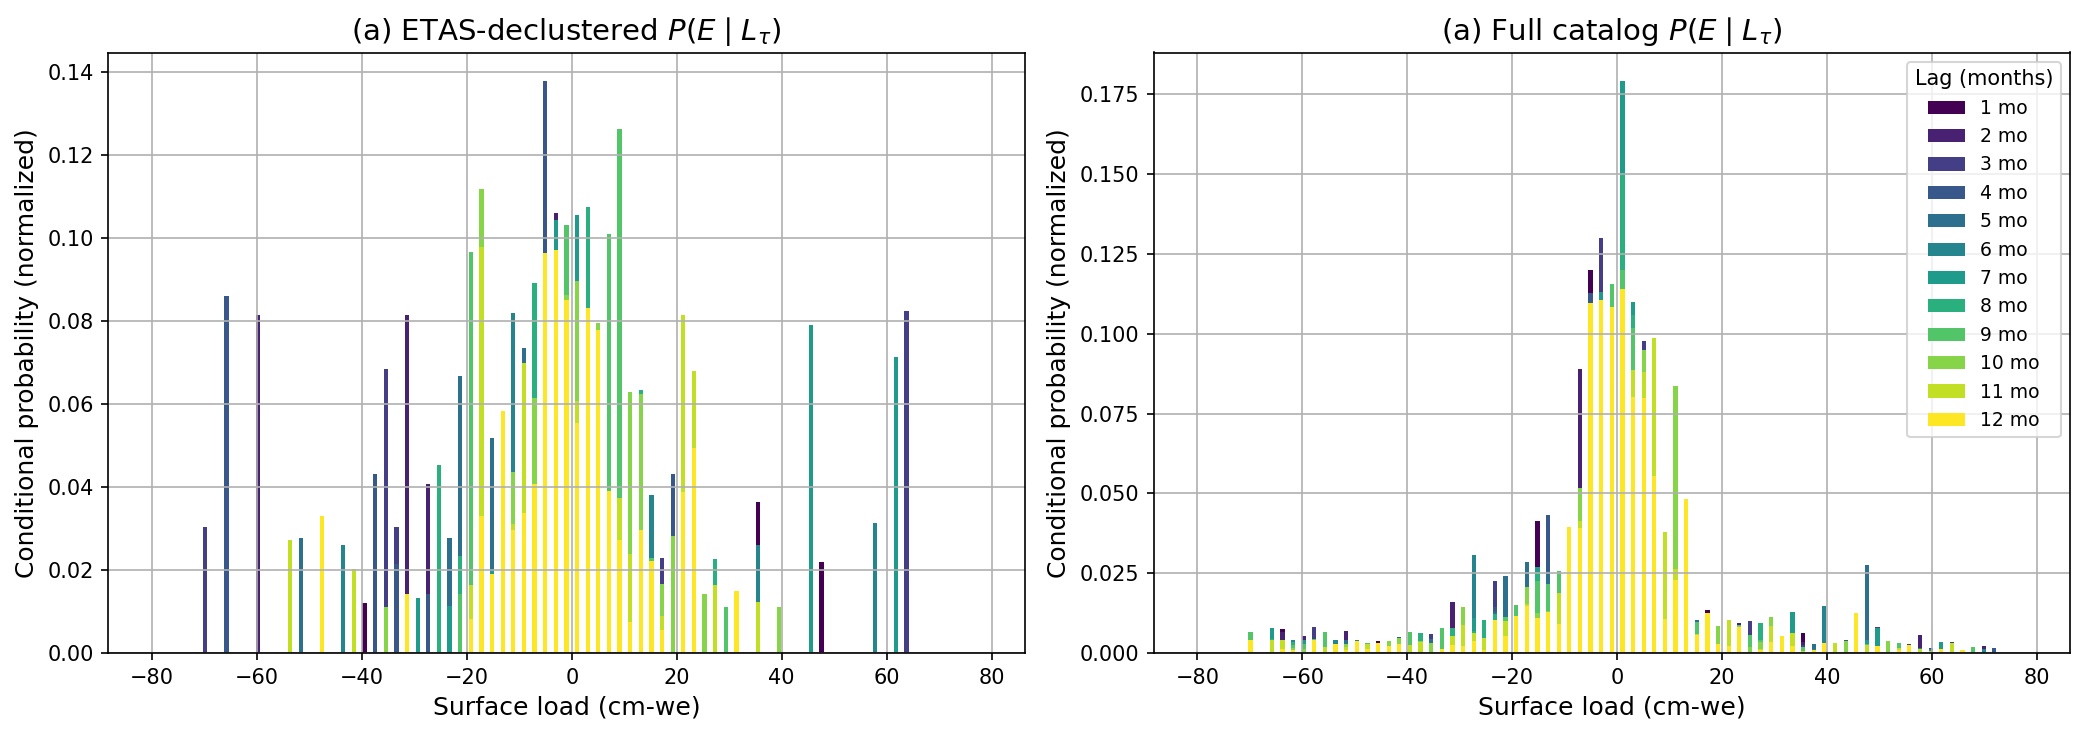

In [9]:
# Average across mascons to get average cp (given lag tau) over all mascons 
cp_tau_mean = np.nanmean(cp_all, axis=0)          # shape (n_tau, n_bins)
etas_cp_tau_mean = np.nanmean(etas_cp_all, axis=0)

# Normalize each by its sum for comparability
cp_tau_norm = cp_tau_mean / np.nansum(cp_tau_mean, axis=1)[:, None]
etas_cp_tau_norm = etas_cp_tau_mean / np.nansum(etas_cp_tau_mean, axis=1)[:, None]

fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=150)
fs = 12
colors = plt.cm.viridis(np.linspace(0, 1, len(taus)))

# (a) ETAS-declustered
for i, tau in enumerate(etas_taus):
    axes[0].bar(etas_bins[:-1], etas_cp_tau_norm[i], color=colors[i], label=f'{tau} mo')

axes[0].set_title(r'(a) ETAS-declustered $P(E\mid L_{\tau})$', fontsize=fs+2)
axes[0].set_xlabel('Surface load (cm-we)', fontsize=fs)
axes[0].set_ylabel('Conditional probability (normalized)', fontsize=fs)
axes[0].grid(True)

# (b) Full catalog
for i, tau in enumerate(taus):
    axes[1].bar(bins[:-1], cp_tau_norm[i], color=colors[i], label=f'{tau} mo')

axes[1].set_title(r'(a) Full catalog $P(E \mid L_{\tau})$', fontsize=fs+2)
axes[1].set_xlabel('Surface load (cm-we)', fontsize=fs)
axes[1].set_ylabel('Conditional probability (normalized)', fontsize=fs)
axes[1].grid(True)
axes[1].legend(title='Lag (months)', fontsize=9)

plt.tight_layout()
plt.show()


## 3.1 Permutation testing

### The code below does the following:
1. Scramble loads (ds.lwe_thickness) and generate randomized data
2. Calculate cp for each randomized load dataset

### Scramble loads for full catalog & ETAS catalog

In [10]:
# Number of randomizations
N = 100

In [11]:
# Time taken to run: ~1 hr 15 mins
# Last run: Oct 31, 2025

N = 100  # number of permutations
taus = np.arange(1, 13)

cp_perm_distribution = []  # list to hold (n_tau, n_bins) results per permutation
etas_cp_perm_distribution = []

import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    
    for i in tqdm(range(N), desc='Permutation test'):

        # Shuffle surface loads
        all_grace_data = np.array(ds['lwe_thickness'].values)
        flat_grace = all_grace_data.ravel()
        np.random.shuffle(flat_grace)
        shuffled_grace = flat_grace.reshape(all_grace_data.shape)

        ds_shuffled = ds.copy(deep=True)
        ds_shuffled['lwe_thickness'].values = shuffled_grace
        
        # --- Full catalog
        # Recalculate lagged conditional probability
        cp_shuffled, bins, taus = calc_cp_by_mascon_lag(
            catalog_gdf_full,
            ds_shuffled['lwe_thickness'],
            taus)

        # Normalize each tau separately
        cp_shuffled_norm = cp_shuffled / np.nansum(cp_shuffled, axis=1, keepdims=True)
        cp_perm_distribution.append(cp_shuffled_norm)
        
        # --- ETAS catalog
        # Recalculate lagged conditional probability
        etas_cp_shuffled, etas_bins, etas_taus = calc_cp_by_mascon_lag(
            catalog_gdf_etas,
            ds_shuffled['lwe_thickness'],
            taus)

        # Normalize each tau separately
        etas_cp_shuffled_norm = etas_cp_shuffled / np.nansum(etas_cp_shuffled, axis=1, keepdims=True)
        etas_cp_perm_distribution.append(etas_cp_shuffled_norm)

    cp_perm_distribution = np.array(cp_perm_distribution)
    etas_cp_perm_distribution = np.array(etas_cp_perm_distribution)
    # Shape: (N, n_tau, n_bins)

Permutation test: 100%|█████████████████████| 100/100 [1:15:37<00:00, 45.38s/it]


## 4. Figures

## 4.1 Convergence Test

In [26]:
def plot_significance(dist_to_plot):
    fig, axes = plt.subplots(1, 4, figsize=(16, 5), dpi=300, sharey=True)
    plt.style.use('fivethirtyeight')
    fs = 13

    # Define different data slices for each subplot
    partial_rds = [
        dist_to_plot[1, :],
        dist_to_plot[1:10, :].flatten(),
        dist_to_plot[1:50, :].flatten(),
        dist_to_plot[1:100, :].flatten(),
    ]

    titles = [
        "Significance Test (N=1)",
        "Significance Test (N=10)",
        "Significance Test (N=50)",
        "Significance Test (N=100)",
    ]

    # Plot each dataset in the 1x4 figure
    for i, (ax, partial_rd, title) in enumerate(zip(axes, partial_rds, titles)):
        partial_flat = partial_rd.flatten()
        sorted_data = np.sort(partial_flat)
        pval = 1 - np.arange(sorted_data.size) / sorted_data.size
        pval = pval

        ax.plot(sorted_data, pval)
        ax.set_xlabel("Probability\nfrom Random Loading", fontsize=fs)
        ax.set_title(title, fontsize=fs + 2)
        ax.set_ylim([-0.01, 0.2])
        ax.text(0.01, 0.02, '99th percentile', color='C1')
        ax.text(0.01, 0.06, '95th percentile', color='C4')
        ax.axhline(y=0.01, color="C1", linestyle="--", label="99th percentile")
        ax.axhline(y=0.05, color="C4", linestyle="--", label="95th percentile")

        if i == 0:  # Add ylabel only to the first subplot for clarity
            ax.set_ylabel("Frequency of Occurrence\nUnder Random Loading\n(p-value)", fontsize=fs)

        ax.grid(True)

    # Layout adjustment
    plt.tight_layout()
    plt.show()

In [49]:
def plot_significance(dist_to_plot):
    fig, axes = plt.subplots(1, 4, figsize=(16, 5), dpi=300, sharey=True)
    plt.style.use('fivethirtyeight')
    fs = 13

    # Average over mascons -- shape becomes (N, n_tau, n_bins)
    dist_to_plot = np.nanmean(dist_to_plot, axis=1)

    partial_rds = [
        dist_to_plot[1, :, :],
        dist_to_plot[1:10, :, :],
        dist_to_plot[1:50, :, :],
        dist_to_plot[1:100, :, :],
    ]

    titles = [
        "Significance Test (N=1)",
        "Significance Test (N=10)",
        "Significance Test (N=50)",
        "Significance Test (N=100)",
    ]

    for i, (ax, partial_rd, title) in enumerate(zip(axes, partial_rds, titles)):
        partial_flat = partial_rd.flatten()
        partial_flat = partial_flat[~np.isnan(partial_flat)]
        if partial_flat.size == 0:
            continue

        sorted_data = np.sort(partial_flat)
        pval = 1 - np.arange(sorted_data.size) / sorted_data.size

        ax.plot(sorted_data, pval)
        ax.set_xlabel("Probability\nfrom Random Loading", fontsize=fs)
        ax.set_title(title, fontsize=fs + 2)
        ax.set_ylim([-0.01, 0.2])
        ax.axhline(y=0.01, color="C1", linestyle="--")
        ax.axhline(y=0.05, color="C4", linestyle="--")
        if i == 0:
            ax.set_ylabel("Frequency of Occurrence\nUnder Random Loading\n(p-value)", fontsize=fs)
        ax.grid(True)

    plt.tight_layout()
    plt.show()


### 4.1.1 Convergence test for shuffled GRACE data across mascons

In [50]:
chosen_dist = cp_perm_distribution

/var/folders/8d/yjj_j8x10pd63nrz4jt7rhrh0000gn/T/ipykernel_96809/505733741.py:7: RuntimeWarning: Mean of empty slice
  dist_to_plot = np.nanmean(dist_to_plot, axis=1)


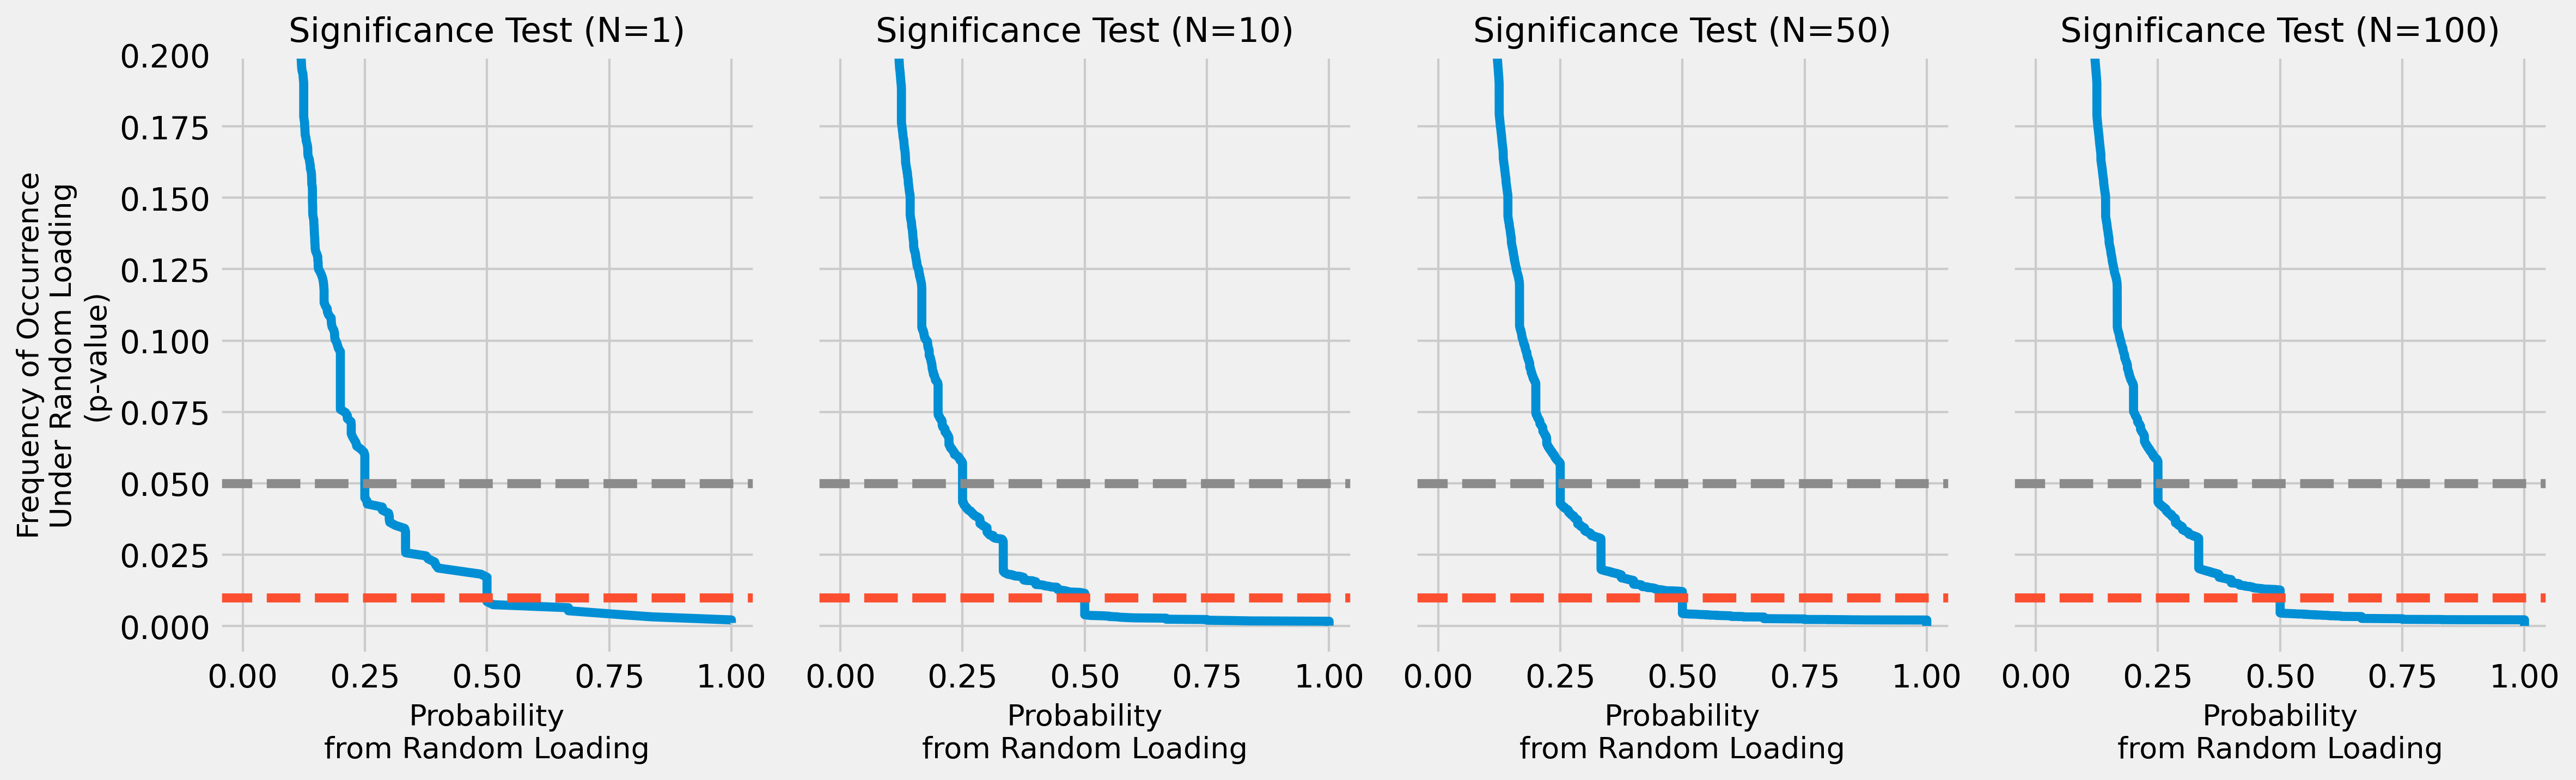

In [51]:
plot_significance(chosen_dist)

In [54]:
print(chosen_dist[1, :] == chosen_dist[99, :])

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False Fal

## 4.2 Significance test & conditional probabilities

In [ ]:
def plot_significance_and_cp(chosen_dist, etas_chosen_dist):
    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(2, 2, figsize=(15, 9))
    fs = 13

    ### (1) Significance Test for Full Catalog
    ax = axes[0, 0]
    wid_etas = np.mean(np.diff(bins))
    full_dist = chosen_dist.flatten()
    sorted_data = np.sort(full_dist)
    pval = 1 - np.arange(sorted_data.size) / sorted_data.size
    ax.plot(sorted_data, pval)
    ax.set_ylabel('Frequency of Occurrence\nUnder Random Loading\n(p-value)', fontsize=fs)
    ax.set_xlabel('Probability\nfrom Random Loading', fontsize=fs)
    ax.set_title('(a) Significance Test for Full Catalog', fontsize=fs + 2)
    ax.set_ylim([-0.05, 0.2])
    significant95 = min(sorted_data[pval < 0.05])
    significant99 = min(sorted_data[pval < 0.01])

    ax.text(0, 0.03, '95th percentile', color='C1')
    ax.axhline(y=0.05, color='C1', linestyle='--')
    ax.plot(significant95, 0.05, 'C1o')
    ax.text(significant95, 0.06, 'x=' + str(round(significant95,3)), color='C1')

    ax.text(0, -0.01, '99th percentile', color='C4')
    ax.axhline(y=0.01, color='C4', linestyle='--')
    ax.plot(significant99, 0.01, 'C4o')
    ax.text(significant99, 0.02, 'x=' + str(round(significant99,3)), color='C4')

    ax.grid(True)

    ### (2) P(E|L) by Mascon (Full Catalog)
    ax = axes[0, 1]
    wid_etas = np.mean(np.diff(bins))
    ax.bar(bins[:-1], cp_averaged / np.sum(cp_averaged), width=wid_etas)
    ax.set_xlim(bins[0], bins[-2])

    ax.set_ylabel('Conditional probability', fontsize=fs)
    ax.set_title('(b) Averaged P(E|L) by Mascon (n=12573)', fontsize=fs + 2)
    ax.text(-75, significant95-0.01, '95th percentile', color='C1')
    ax.axhline(y=significant95, color='C1', linestyle='--')
    ax.text(-75, significant99-0.01, '99th percentile', color='C4')
    ax.axhline(y=significant99, color='C4', linestyle='--')
    ax.grid(True)
    ax.set_ylim([0, 0.12])

    ### (3) Significance Test for ETAS Declustered Catalog
    ax = axes[1, 0]
    wid_etas = np.mean(np.diff(bins))
    full_dist = etas_chosen_dist.flatten()
    sorted_data = np.sort(full_dist)
    pval = 1 - np.arange(sorted_data.size) / sorted_data.size
    ax.plot(sorted_data, pval)
    ax.set_ylabel('Frequency of Occurrence\nUnder Random Loading\n(p-value)', fontsize=fs)
    ax.set_xlabel('Probability\nfrom Random Loading', fontsize=fs)
    ax.set_title('(c) Significance Test for Declustered Catalog', fontsize=fs + 2)
    ax.set_ylim([-0.05, 0.2])
    significant95 = min(sorted_data[pval < 0.05])
    significant99 = min(sorted_data[pval < 0.01])
    ax.text(0, 0.03, '95th percentile', color='C1')
    ax.axhline(y=0.05, color='C1', linestyle='--')
    ax.plot(significant95, 0.05, 'C1o')
    ax.text(significant95, 0.06, 'x=' + str(round(significant95,3)), color='C1')
    ax.text(0, -0.01, '99th percentile', color='C4')
    ax.axhline(y=0.01, color='C4', linestyle='--')
    ax.plot(significant99, 0.01, 'C4o')
    ax.text(significant99, 0.02, 'x=' + str(round(significant99,3)), color='C4')
    ax.grid(True)

    ### (4) P(E|L) by Mascon (Declustered Catalog)
    ax = axes[1, 1]
    wid_etas = np.mean(np.diff(bins))
    norm_cp_etas = etas_cp_averaged / np.sum(etas_cp_averaged)
    ax.bar(bins[:-1], norm_cp_etas, width=wid_etas, align='edge')
    ax.set_xlim(bins[0], bins[-2])
    ax.set_xlabel('Surface load (cm-we)', fontsize=fs)
    ax.set_ylabel('Conditional probability', fontsize=fs)
    ax.set_title('(d) Averaged P(E|L) by Mascon (n=537)', fontsize=fs + 2)
    ax.text(-75, significant95-0.015, '95th percentile', color='C1')
    ax.axhline(y=significant95, color='C1', linestyle='--')
    ax.text(-75, significant99-0.015, '99th percentile', color='C4')
    ax.axhline(y=significant99, color='C4', linestyle='--')

    # ax.axvline(sig_bins_left[0], color='C5')
    # ax.axvline(sig_bins_right[1], color='C3')
    ax.grid(True)

    # Layout adjustment
    plt.tight_layout()
    plt.show()

### 4.1.1 Significance threshold for shuffled GRACE data across mascons

In [ ]:
chosen_dist = cp_perm_distribution
etas_chosen_dist = etas_cp_perm_distribution

plot_significance_and_cp(chosen_dist, etas_chosen_dist)